In [1]:
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from constants import *
from obsplan import *
from LCz import *
from LCz_Av import *
from SFHs import *
from survey import *

# Cosmology stuff                                                                                                                                     
sys.path.append("../cos_calc")
import cos_calc

In [3]:
# filtername                                                                                                                                      
filtername = 'g'
modelfile = "13z002E1.0.dat"
obsname = "CFHT-MegaCam" #Blanco-DECam" #"KMTNet"                                                                                                   

In [4]:
# start an observational plan                                                                                                                     
customplan = obsplan(obsname = obsname, band = filtername, mode = 'custom', nfields = 50, nepochspernight = 1, ncontnights = 21, nnights = 21, ni\
ghtfraction = 1. / 5., nread = 1, startmoonphase = -3, maxmoonphase = 12, doplot = False)

Observation plan name: custom-nf50-ne1-nr1-nc21-nn21_CFHT-MegaCam_g
Number of fields to visit: 50, exposure time: 78.8


In [5]:
# light curve model                                                                                                                               
SN = StellaModel(dir = "/home/fforster/Work/Model_LCs/models", modelfile = modelfile, doplot = False)

In [6]:
# extinction                                                                                                                                      
lAv = 0.187
nAv = 10
Avs = np.linspace(0, 4. * lAv, nAv)# np.hstack([0, np.logspace(-1.5, 0, 10)])                                                                     
Rv = 3.1

In [7]:
# star formation history and efficienciy                                                                                                          
SFH = SFHs(SFH = "MD14")

In [8]:
# conversion efficiency between star formation and explosions                                                                                     
knorm = 0.0091
IIPfrac = 0.54
efficiency = knorm * IIPfrac

In [9]:
# number of redshift bins                                                                                                                         
nz = 20 #20 #20                                                                                                                                   

In [10]:
# start survey                                                                                                                                    
newsurvey = survey(obsplan = customplan, LCz = SN, Avs = Avs, Rv = Rv, lAv = lAv, SFH = SFH, efficiency = knorm * IIPfrac, filtername = 'g', nz =\
 nz)

In [11]:
# estimate maximum survey redshift (for Montecarlo simulation)                                                                                                               
newsurvey.estimate_maxredshift(zguess = 0.334, minprobdetection = 1e-4, minndetections = 2)

   Looking for maximum redshift...
Redshift: 0.33, start of peak: 1.533374 obs. days, peak: 1.552695 obs. days, end of peak: 1.616520 obs. days, 1 day after end of peak: 3.421153 obs. days, maximum: 17.866240 obs. days
Redshift: 0.33, start of peak: 1.537223 obs. days, peak: 1.556593 obs. days, end of peak: 1.620578 obs. days, 1 day after end of peak: 3.429741 obs. days, maximum: 17.536871 obs. days
Redshift: 0.34, start of peak: 1.541072 obs. days, peak: 1.560490 obs. days, end of peak: 1.624635 obs. days, 1 day after end of peak: 3.438328 obs. days, maximum: 17.580779 obs. days
      Correction applied. Current range is [ 0.33066  0.334    0.33734]
Redshift: 0.33, start of peak: 1.533297 obs. days, peak: 1.552617 obs. days, end of peak: 1.616439 obs. days, 1 day after end of peak: 3.420982 obs. days, maximum: 17.865343 obs. days
Redshift: 0.34, start of peak: 1.541072 obs. days, peak: 1.560490 obs. days, end of peak: 1.624635 obs. days, 1 day after end of peak: 3.438328 obs. days, ma

In [12]:
# compute redshifts                                                                                                                               
newsurvey.compute_zs()

In [13]:
# update cosmology                                                                                                                                
newsurvey.do_cosmology()

In [14]:
# compute magnitudes                                                                                                                              
newsurvey.compute_mags()

      Computing magnitudes...
Redshift: 0.02, start of peak: 1.172978 obs. days, peak: 1.186936 obs. days, end of peak: 1.242572 obs. days, 1 day after end of peak: 2.210652 obs. days, maximum: 19.558673 obs. days
Redshift: 0.03, start of peak: 1.192817 obs. days, peak: 1.207011 obs. days, end of peak: 1.263588 obs. days, 1 day after end of peak: 2.281612 obs. days, maximum: 19.889476 obs. days
Redshift: 0.05, start of peak: 1.212494 obs. days, peak: 1.227086 obs. days, end of peak: 1.284604 obs. days, 1 day after end of peak: 2.353689 obs. days, maximum: 19.361069 obs. days
Redshift: 0.07, start of peak: 1.232330 obs. days, peak: 1.247161 obs. days, end of peak: 1.305620 obs. days, 1 day after end of peak: 2.392195 obs. days, maximum: 19.303547 obs. days
Redshift: 0.09, start of peak: 1.252001 obs. days, peak: 1.267236 obs. days, end of peak: 1.324200 obs. days, 1 day after end of peak: 2.467549 obs. days, maximum: 19.233976 obs. days
Redshift: 0.10, start of peak: 1.271834 obs. days,

In [15]:
# sample from distribution                                                                                                                        
newsurvey.sample_events(nsim = 100000)

      Sampling light curves...


LCz_Av.py:73: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  texp = tmin + np.random.random(nsim) * (tmax - tmin)
LCz_Av.py:75: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  iAv = map(lambda i: int(self.random2iAv(i)), np.random.random(nsim))


      Plotting light curves and statistics...


/home/fforster/miniconda2/lib/python2.7/site-packages/matplotlib/axes/_axes.py:519: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


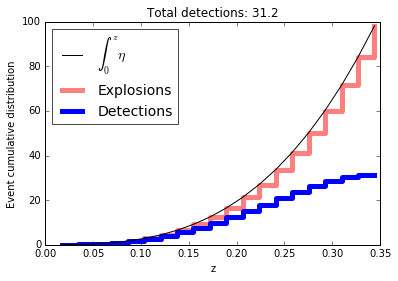

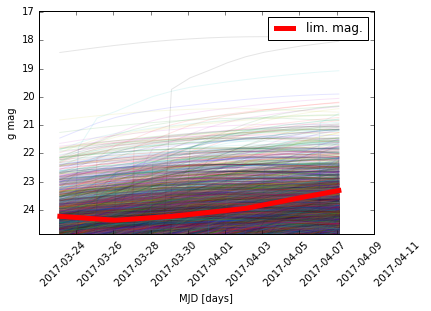

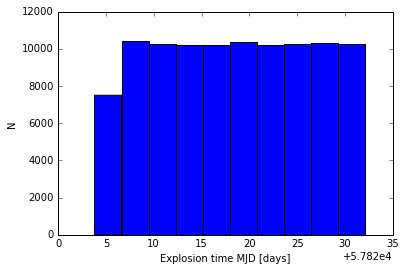

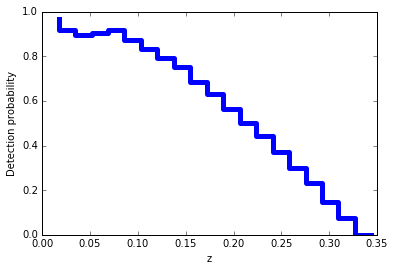

In [16]:
# plot light curves                                                                                                                               
newsurvey.plot_LCs(save = True)